# GSI Land Classification Primer
#### Author: Alexey Tarutin

This notebook gives an overview of the proposed GSI land classification mechanism, alongside results from a previous project in the same area of interest. The point of this is to improve upon this using notions of textural and windowed predictions based purely on optical imagery from a single date.

This notebook outlines the following:
* Reading the data
* Clipping the data to the AOI
* Preparing the data for machine learning
* Training/prediction
* Accuracy validation
* Post-processing
* Writing output

Supplemental material to this notebook:
* In the data/ directory
 * A Level 2 Sentinel-2 Scene from 28th of November 2017
 * A land classification map based on Corine from 2018 for training
 * Field boundaries for the area courtesy of the Centre for Ecology and Hydrology for aggregation of results
 * Validation boundaries created by GSI
* environment.yml to create the Anaconda environment on your local machine. If you don't use Anaconda, please install the Python 3 distribution for your system: https://docs.conda.io/en/latest/miniconda.html
 * This is populated with the following command: `conda env create -f environment.yml`
 * Activate with: `conda activate geo`

In [1]:
import rasterio as rio
import geopandas as gpd
from fiona.crs import from_epsg
import os
import sys
from glob import glob
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pylab as pl
from shapely.geometry import box as geobox
from rasterio.mask import mask
from rasterstats import zonal_stats

## Step 1
Create a GeoJSON file using the coordinates for the area. This is to allow us to validate and verify data fit.

In [2]:
aoi_geo = geobox(-2.29, 51.51, -1.71, 51.61)
aoi = gpd.GeoDataFrame([], geometry=[aoi_geo])
aoi.crs = from_epsg(4326)
aoi.to_file('./data/aoi.geojson', driver='GeoJSON')

We have prepared a package named `land_classification` that gives a simple structure for file IO, dataset sampling and cleaning, machine learning, output validation, and postprocessing.

You are welcome to modify functions in this as appropriate. Expect bugs.

In [3]:
import land_classification as lc

## Step 2
Load in Sentinel-2 scene data. 

Notes:
* We are only using a single scene for this exercise. We want to maximise our ability to create land classification maps on only one image, this will also help us extend this to other applications such as change detection and phenology analysis.
* This scene was downloaded from the Sentinel-2 Google Cloud Storage repository in SAFE format as Level-1C. This file was then processed to Level-2A using Sen2Cor for the advantages it provides, including atmospheric correction and improved cloud detection. Further information about level 2 Sentinel-2 imagery, advantages, and the relevant algorithms is available here: https://sentinel.esa.int/web/sentinel/technical-guides/sentinel-2-msi/level-2a/algorithm

In [4]:
s2_band = 'S2A_MSIL2A_20171128T111411_N0206_R137_T30UWC_20171128T130743.SAFE'
data, profile = lc.merge_bands(s2_band)
lc.write_raster('data/merged.tif', data, profile)

Writing raster data/merged.tif with 4 bands.
Writing band 1 of 4
Writing band 2 of 4
Writing band 3 of 4
Writing band 4 of 4
File data/merged.tif written.


In [5]:
lc.mask_raster(aoi, 'data/merged.tif', 'data/masked.tif')

Writing raster data/masked.tif with 4 bands.
Writing band 1 of 4
Writing band 2 of 4
Writing band 3 of 4
Writing band 4 of 4
File data/masked.tif written.


In [4]:
bands = ['B02', 'B03', 'B04', 'B08']
pe = lc.PointExtractor(aoi)
points_df = pe.get_n(3000)

points_df = lc.sample_raster(points_df, 'data/Corine_10m_OS_AoI1.tif', bands=['labels'])
points_df = lc.sample_raster(points_df, 'data/masked.tif', bands = bands)
points_df = lc.calc_indices(points_df)

/home/alexey/miniconda3/envs/geo/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Writing raster lc_10m_mlp_pred.tif with 1 bands.
Writing band 1 of 1
File lc_10m_mlp_pred.tif written.
Writing raster lc_10m_mlp_proba.tif with 1 bands.
Writing band 1 of 1
File lc_10m_mlp_proba.tif written.


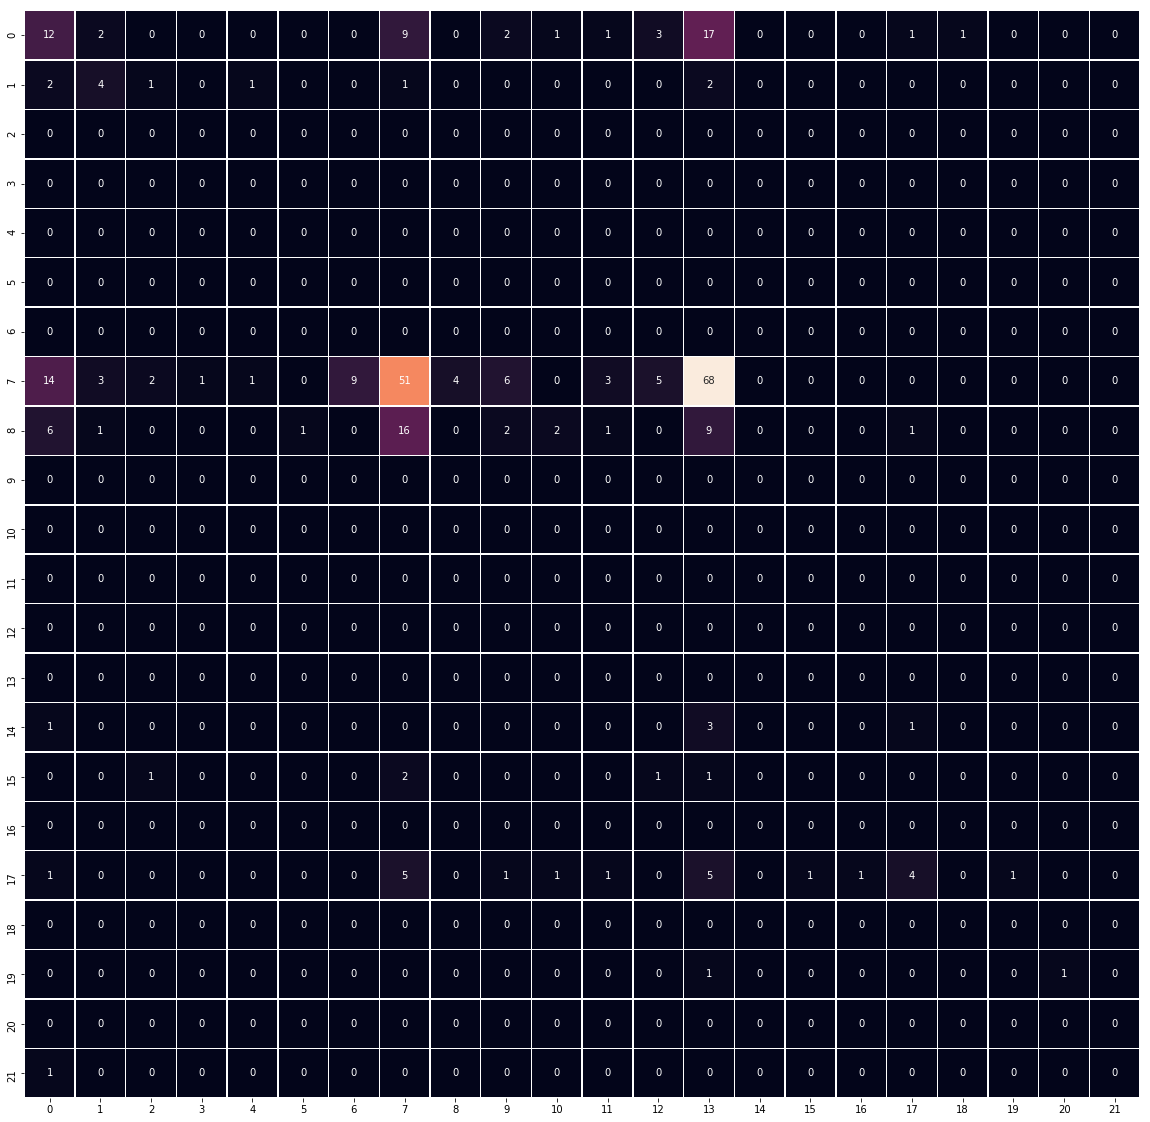

In [5]:
lc.classify(points_df)